# Tree Shap

To get a sense of the Shap library that we'll be using, let's implement the simple version of the Tree Shap algorithm.  This is based on Scott Lundberg's paper [Consistent Individualized Feature Attribution for Tree
Ensembles](https://arxiv.org/pdf/1802.03888.pdf)

#### Training and re-using a single tree model

You may notice that calculating Shap values for every feature, and for every individual data point, is very computationally expensive.  For example, we would be training multiple models just to calculate the importance of one feature.

With decision trees, we can actually train a decision tree on all the features, and then re-use that single tree to calculate shapley values using subsets of that single tree.


![alt text](./tree_shap_images/tree_shap_img_01.png)

For some intuition, let’s look at a model that has just two features.  The tree splits on feature one first, and then on feature 2. 

![tree_shap_img_02.png](./tree_shap_images/tree_shap_img_02.png)

If we wanted to see how a model would perform if it only used the first feature, we could look at the subtree that consists of the top three nodes of this tree.

![tree_shap_img_03.png](./tree_shap_images/tree_shap_img_03.png)

Similarly, if we wanted to see how a model would make predictions if it used only feature 2, we could look at the subtree containing the bottom three nodes, starting at the node that splits on feature 2.  

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_04.png)

#### Another example with 3 features
Now let’s look at a tree that is trained on three features.  Let’s say it splits on feature 1, then on feature 2, then on feature 3.  

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_05.png)

How do we simulate the prediction of a tree that was only trained on features 1 and 3, but not on feature 2?

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_06.png)

Well, if we didn’t split on feature 2, that means that we would include the training samples in both the left and right sub-tree of that node when making a prediction.  This is how we can simulate that the tree never split on feature 2.

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_07.png)

Let’s also think about how we handle the predictions when we do split on the feature.  If we split on feature 3, and the particular data point we’re making a prediction for ends up in the left child node, then we can use the prediction based on training samples in the left sub-tree, and ignore the training samples in the right sub-tree.  

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_08.png)

We’ll walk through the algorithm to do this, and then you’ll get to practice this yourself.

#### Algorithm

Here’s the algorithm used to calculate the prediction of a tree, given a subset of features.  You can check out the paper [Consistent Individualized Feature Attribution for Tree Ensembles](https://arxiv.org/pdf/1802.03888.pdf), page 4 algorithm 1.

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_09.png)

Here, $G$ is a function that gets called recursively to walk down the tree starting at the root node.  $w$ is the weight given to the predictions of each node.  $v$ is the prediction of a leaf node.  $r_{a_j}$ and $r_{b_j}$ are the number of data points in the left and right child nodes of node $j$.  $r_j$ is the number of data points in node $j$.

We can use this to walk through a decision tree that is trained on all features, and calculate the prediction of a tree that would have been created from a subset of the features.

Let's look at specific parts of this algorithm in more detail.

#### leaf nodes
Let's look at the the line that handles leaf nodes.  It takes the prediction of that leaf node and multiplies it by some weight.  The weight is determined by the proportion of training data points that end up reaching that leaf node.

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_10.png)

#### ignoring a feature
Next, let’s look at the case when the feature that’s used at a node is not within the subset of features that we want to split on.  In other words, we want to pretend that we didn’t train the model on this feature.  In that case, in order to pretend that we’re not splitting on that feature, we take the sum of the weighted predictions from both its left and right subtree.

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_11.png)

#### including a feature

Finally, for cases when the feature at that node is within the subset of features that we want to use, then we can follow just the left subtree or just the right subtree, whichever path that the input data gets assigned to by the split.

![tree_shap_img_04.png](./tree_shap_images/tree_shap_img_12.png)

#### Implement it in code!
You’ll get to practice this algorithm!

In [1]:
import sklearn.ensemble
import shap
import numpy as np
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

## generate sample data

Feature 0 and feature 1 form the AND operator, and feature 2 does not contribute to the prediction of the label, because it's always zero.

In [2]:
# AND case (features 0 and 1)
N = 100
M = 3
X = np.zeros((N,M))
X.shape
y = np.zeros(N)
X[:1 * N//4, 1] = 1
X[:N//2, 0] = 1
X[N//2:3 * N//4, 1] = 1
y[:1 * N//4] = 1

## Train a decision tree


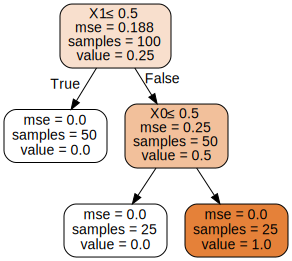

In [3]:
# fit model
model = sklearn.tree.DecisionTreeRegressor(random_state=0)
model.fit(X, y)

# draw model
dot_data = sklearn.tree.export_graphviz(model, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Tree attributes

[sklearn.tree.tree._tree](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx)

```
The binary tree is represented as a number of parallel arrays. The i-th
    element of each array holds information about the node `i`. Node 0 is the
    tree's root.
```

In [4]:
tree0 = model.tree_

####  left and right child nodes
```
children_left : array of int, shape [node_count]
        children_left[i] holds the node id of the left child of node i.
        For leaves, children_left[i] == TREE_LEAF. Otherwise,
        children_left[i] > i. This child handles the case where
        X[:, feature[i]] <= threshold[i].
    children_right : array of int, shape [node_count]
        children_right[i] holds the node id of the right child of node i.
        For leaves, children_right[i] == TREE_LEAF. Otherwise,
        children_right[i] > i. This child handles the case where
        X[:, feature[i]] > threshold[i].
```

In [5]:
print(f"tree0.children_left: {tree0.children_left}")
print(f"tree0.children_right: {tree0.children_right}")

tree0.children_left: [ 1 -1  3 -1 -1]
tree0.children_right: [ 2 -1  4 -1 -1]


#### features
```
    feature : array of int, shape [node_count]
        feature[i] holds the feature to split on, for the internal node i.
    threshold : array of double, shape [node_count]
        threshold[i] holds the threshold for the internal node i.
    value : array of double, shape [node_count, n_outputs, max_n_classes]
        Contains the constant prediction value of each node.
    impurity : array of double, shape [node_count]
        impurity[i] holds the impurity (i.e., the value of the splitting
        criterion) at node i.
```

In [6]:
print(f"tree0.feature: {tree0.feature}")

tree0.feature: [ 1 -2  0 -2 -2]


For Node 0, feature 1 is used to split the data . For Node 2, feature 0 is used for splitting.  For the other nodes (1, 3, 4), there are no features used for splitting.

#### Thresholds

In [7]:
print(f"tree0.threshold: {tree0.threshold}")

tree0.threshold: [ 0.5 -2.   0.5 -2.  -2. ]


The threshold divides the data points using the chosen feature.  <= 0.5 and the data go to the left child; > .5 and the data go in the right child.  The -2 is for nodes that don't split on any feature.

#### Value

In [8]:
print(f"tree0.value : \n{tree0.value}")

tree0.value : 
[[[0.25]]

 [[0.  ]]

 [[0.5 ]]

 [[0.  ]]

 [[1.  ]]]


`value` is the average prediction for each node.  Node 0 predicts 0.25 on average.  Node 2 predicts 0.5 on average.

#### node samples
```
n_node_samples : array of int, shape [node_count]
        n_node_samples[i] holds the number of training samples reaching node i.

weighted_n_node_samples : array of int, shape [node_count]
        weighted_n_node_samples[i] holds the weighted number of training samples
        reaching node i.
```

In [9]:
print(f"tree0.n_node_samples : {tree0.n_node_samples}")
print(f"tree0.weighted_n_node_samples : {tree0.weighted_n_node_samples}")

tree0.n_node_samples : [100  50  50  25  25]
tree0.weighted_n_node_samples : [100.  50.  50.  25.  25.]


The n_node_samples counts how many data points from the parent gets passed to each child node.  `weighted_n_node_samples` is the same in this case, because it's a single decision tree.  If this were a tree within a random forest, 2/3 of the training data may be sampled and used to train a tree.  The `weighted_n_node_samples` would then be re-scaled to equal the total sample size.  We can use either in the calculations we'll do below.

#### Quiz
What proportion of samples went to the left child and right child of the root node?

In [10]:
# TODO
proportion_in_left_child = 0.5
proportion_in_right_child = 0.5
print(f"proportion of samples in left child of root node {proportion_in_left_child}")
print(f"proportion of samples in left child of root node {proportion_in_right_child}")

proportion of samples in left child of root node 0.5
proportion of samples in left child of root node 0.5


## Wrap with Tree class

To make the tree object easier to work with, we'll wrap it inside our custom Tree class.  Please complete the functions within the Tree class below.

**Bonus Challenge:** Try implementing your own wrapper class for the tree object.

Think about attributes that you may need in order to implement algorithm 1.  For example, how do we know when a node is an internal or leaf node?  What fraction of samples are in the left child relative to its parent node?  On which node is each feature split on?

In [ ]:
"""
Challenge: try implementing your own wrapper class
"""



**If you prefer some starter code:** You can also use the starter code below if you prefer.

In [ ]:
NO_NODE = -1
NO_FEATURE = -2
class Tree:
    
    def __init__(self, tree):
        if str(type(tree)).endswith("'sklearn.tree._tree.Tree'>"):
            self.weight = 1 
            self.children_left = tree.children_left
            self.children_right = tree.children_right
            self.features = tree.feature
            self.thresholds = tree.threshold
            self.values = tree.value[:,0,0] # tree.value is n by 1 by 1; get the n prediction values (there are n nodes in tree)
            self.n_node_samples = tree.n_node_samples # actual number of nodes
            self.node_sample_weight = tree.weighted_n_node_samples #rescaled number of nodes

    def is_internal(self,i):
        return (self.children_left[i] != NO_NODE or self.children_right[i] != NO_NODE)

    def is_leaf(self,i):
        # TODO
        
            
    def left_child(self,i):
        return self.children_left[i]

    def right_child(self,i):
        # TODO
        

    def proportion_of_samples_in_left_child(self,i):
        # TODO
        
    
    def proportion_of_samples_in_right_child(self,i):
        # TODO
        

    def node_prediction(self,i):
        return self.values[i]

    def feature_that_split_node_i(self,i):
        return self.features[i]

    def threshold_at_node_i(self,i):
        return self.thresholds[i]

In [ ]:
tree_wrap = Tree(tree0)

#### Calculate the prediction of a tree model, given a subset of features

We'll implement algorithm 1 of Scott Lundberg's paper.  This is a way to use a single trained tree to estimate predictions of other trees that would be trained on a subset of the features.

**Bonus challenge:** Try implementing this function completely by yourself!

In [ ]:
"""Bonus challenge: implement f_given_S on your own!"""
def f_given_S(tree, S, x):
    """
    tree: the custom Tree class
    S: set of integers reprenting features that are used to train the model.
    x: sample observation on which to calculate the prediction of the model.
    """
    pass

**If you prefer some starter code:** You can also use the starter code below to implement the algorithm.

In [ ]:
"""
You can use this starter code if you get stuck while implementing the algorithm on your own
"""
def f_given_S(tree, S, x):
    """
    tree: the custom Tree class
    S: set of integers reprenting features that are used to train the model.
    x: sample observation on which to calculate the prediction of the model.
    """
    # the root node is at index 0 in the list
    starting_node = 0
    # When starting at the root node, the weight assigned is 1 (100%).
    starting_weight = 1

    def traverse_tree(node_i, weight):
        """
        nested function that will be called recursively
        """
        if tree.is_leaf(node_i):
            # TODO: multiply the weight times the node prediction
            
        else: # is internal node
            feature_index = tree.feature_that_split_node_i(node_i)
            feature_value = x[feature_index]
            threshold = tree.threshold_at_node_i(node_i)
            left_child = tree.left_child(node_i)
            right_child = tree.right_child(node_i)
            if feature_index in S:
                if feature_value <= threshold:
                    # TODO: recursively traverse the left subtree
                    
                else:
                    # TODO: recursively traverse the right subtree
                    
            else: #feature is not in subset S
                # TODO: traverse the left sub-tree,
                # and update the weight to be the current weight times the proportion of samples in the left child node
                
                
                # TODO: traverse the right sub-tree,
                # and update the weight to be the current weight times the proportion of samples in the left child node
                
                
                # TODO: return the sum of both sub-trees
                
    
    # start traversing the tree
    return traverse_tree(starting_node,starting_weight)

#### Try out the function

In [ ]:
sample_values = np.array([1,1,1])
S = set([2]) # if you input only feature 2, expect 0.25
f_given_S(tree_wrap, S, sample_values)

#### try empty feature set

In [ ]:
S = set([]) #for empty set, expect output to be 0.25

f_given_S(tree_wrap, S, sample_values)

## calculate weight on marginal contribution

We'll calculate the weight placed on the marginal contribution of the feature:
$ \frac{|S|! (M - |S| -1 )!}{M!}$

In [ ]:
from math import factorial
def weight_on_marginal_contribution(size_S, M):
    """
    size_S: number of features in set S
    M: numer of total features
    """
    # TODO
    

## calculate marginal contribution for a single feature 

$ f(S \cup i) - f(S)$  

Fill in the function that takes in the custom Tree object, a sample data point, a list containing the set of features in set S (excluding feature "i"), and also the feature for which we want to calculate the marginal contribution.  Keep in mind that set S excludes feature "i".

**Hint:** The python `set` class has the member function `.add`.  
Note that you may need to use the `.copy` function as well.

In [ ]:
def marginal_contribution_of_feature(tree,x,S,feature_i):
    """
    tree: the custom Tree object that wraps the sklearn tree_ object
    x: a sample observation that contains all features
    S: a list of integers, specifying the features in subset S, excluding feature i.
    feature_i: an integer specifying the feature for which we're calculating the marginal contribution.
    """
    # TODO: create the union of S and i
    
    # TODO: return the difference in prediction with feature "i" and without feature "i"


#### Try it out

We'll try out the `marginal_contribution_of_feature` function.  

In [ ]:
feature_i = 0 #index of feature for which we want to calculate its marginal contribution
S = set([1]) # Set that excludes feature i
x = X[0] #grab one data point to calculate marginal contribution on
marginal_contribution_of_feature(tree_wrap,x,S,feature_i) # we expect 0.5

The marginal contribution of feature 0 is 0.5.  This means that the prediction of the model when feature 0 is present is 0.5 greater than the model's prediction when it only has feature 1.

## Generate all subsets

Fill in a function that generates all possible subsets S.  
We'll use `itertools.combinations`, which takes in a list, and also the size of each subset.  It returns an iterable object that contains tuples of all the combinations.



In [ ]:
from itertools import combinations

# try out the combinations function
tmp_combo = combinations([1,2,3,4],2)
for subset in tmp_combo:
    print(subset)

#### fill in the function generate_all_subsets

Keep in mind that since the iterable returned by `combinations` holds tuples, we can create sets out of the tuples by using `set(the_tuple_object)`.  We'll store the S sets as `set` types, since we defined the `f_given_S` function to take S as a type `set`.

Remember to also include the empty set.  We can do this with `set([None])`

** Bonus challenge:** Try implementing this function on your own!

In [ ]:
"""
Try implementing on your own!
"""
def generate_all_subsets(S):
    """
    S: set of integers representing the features in set S
    """
    pass


**If you prefer some starter code: ** You can also use the starter code if you get stuck

In [ ]:
"""
Starter code version
"""

def generate_all_subsets(S):
    """
    S: set of integers representing the features in set S
    """
    sets_l = []
    for size in range(1,len(S)+1):
        # TODO: create a combinations iterable

        # TODO: loop thru the combo iterable and append sets to the sets_l list
            
    # TODO: also include the empty set

    return sets_l

#### Try out the function

In [ ]:
S = set([0,1,2])
generate_all_subsets(S)

## Calculate shapley value for one feature

Implement a function that calculates the shapley value for a single feature, by iterating across all subsets S.

**Bonus challenge:** Try implementing the function yourself!

In [ ]:
def shap_feature_i(tree,x,feature_i):
    """
    tree: the custom Tree object that wraps the tree_ from sklearn.
    x: a sample data point
    i: the feature for which we want to calculate its shapley value.
    """
    pass

**If you prefer starter code:** You can also fill in the starter code below if you prefer.

In [ ]:
def shap_feature_i(tree,x,feature_i):
    """
    tree: the custom Tree object that wraps the tree_ from sklearn.
    x: a sample data point
    i: the feature for which we want to calculate its shapley value.
    """
    all_features = set(np.arange(0,x.shape[0]))
    all_features_minus_i = all_features.copy()
    all_features_minus_i.remove(feature_i) #remove feature "i"

    # TODO: generate all subsets S
    S_list = # ...
    phi = # ...
    num_features_total = len(all_features)
    
    # iterate thru S_list
    for S in S_list:
        # TODO: calculate the number of features stored in S
        # Handle the special case where S contains None, because the number of features should be 0 in that case
        if None in S and len(S) == 1:
            # ...
        else:
            # ...
            
        # TODO: increment phi by the weigth on the marginal contribution * marginal contribution of "i"
        phi += # ...
    
    return np.round(phi,decimals=3)
    return phi

#### Try out the function

In [ ]:
x = X[0]
shap_feature_i(tree_wrap,x,0)

## Calculate feature importance of all features

In [ ]:
def shap_tree_explainer(tree_wrap, x):
    shap_l = []
    for i,v in enumerate(x):
        shap_l.append(shap_feature_i(tree_wrap, x,i))
    
    return np.array(shap_l)

## Take an sklearn tree model and calculate feature importance

In [ ]:
def shap_tree_model_explainer(tree_model, x):
    sklearn_tree = tree_model.tree_
    tree_wrap = Tree(tree_model.tree_)
    
    return shap_tree_explainer(tree_wrap,x)

# Additive Feature Attribution

Additive feature attribution methods are simple models that are used to explain complex models.  You can see the formula in the same paper on page 3.

![alt text](./tree_shap_images/tree_shap_img_13.png)

#### Explanation

Think of our tree model as the complex model that we wish to explain with a simple, linear model.  The above formula is saying that we can take a single data point with the three features, and the complex model makes a prediction.  We can divide up that prediction among the three features, based on how important those features are to the complex model's prediction, and also based on whether the feature values push the prediction in the positive or negative direction.

This is related to the ideas of coalition game theory.  Imagine a team of basketball players scores 100 points in a game. We are trying to attribute part of the final score to each member of the team, based on their contributions, or "importance."

When the contributions of each feature are added up to equal the complex model's prediction, this linear combination of contributions is the simple linear model that is being used to explain the complex model.

#### Example

Let's say that we've trained a complex model on 3 features.  If it's given no inputs to make a prediction, then its prediction would be the equal weighted average of all its training samples.  
Let's say that equal weighted average of the training labels is **100**.  In other words, if a model is given no features and asked to make a prediction, it would predict 100, which is the expected value based on the training labels.

Now, let's say we give the complex model a single sample observation, with all three features, and the complex model gives a prediction of **200**.  

The additive feature attribution model may assign feature importances to the three features like this:  
feature 0: +50  
feature 1: +90  
feature 2: -40  

So this is saying that feature 0 pushed the complex model's prediction up by 50, feature 1 pushed the complex model's prediction up by 90, and feature 2 pushed the model's prediction down by 40.  The end result was to go from the expected value of 100 to the prediction of 200.

The shapley values that we just calculated are these values that push the model's prediction from the average of the training labels to the model's final prediction.  When we add up the shapley values for all the features, they add up to the model's prediction.

## Compare this implementation with shap library

#### test 1

In [ ]:
x = np.array([0,0,0])
shap_values = shap_tree_model_explainer(model,x)
expected_value = np.mean(y)
print(f"my shap function: {shap_values}")
print(f"shap library:     {shap.TreeExplainer(model).shap_values(x)}")
print(f"expected value (average of labels in y) {expected_value}")
print(f"sum of shapley values for all features: {np.sum(shap_values)}")
print(f"model prediction {model.predict(x.reshape(1,-1))}")

#### Quiz

How do you interpret the shapley values of each feature when features 0,1 and 2 are all 0?

#### Answer



#### test 2

In [ ]:
x = np.array([1,0,0])
shap_values = shap_tree_model_explainer(model,x)
print(f"my shap function: {shap_values}")
print(f"shap library:     {shap.TreeExplainer(model).shap_values(x)}")
print(f"expected value (average of labels in y) {expected_value}")
print(f"sum of shapley values for all features: {np.sum(shap_values)}")
print(f"model prediction {model.predict(x.reshape(1,-1))}")

#### Quiz

How do you interpret the shapley values of each feature when feature 0 is 1 and the other features are 0?

#### Answer



#### test 3

In [ ]:
x = np.array([1,1,0])
shap_values = shap_tree_model_explainer(model,x)
print(f"my shap function: {shap_values}")
print(f"shap library:     {shap.TreeExplainer(model).shap_values(x)}")
print(f"expected value (average of labels in y) {expected_value}")
print(f"sum of shapley values for all features: {np.sum(shap_values)}")
print(f"model prediction {model.predict(x.reshape(1,-1))}")

#### Quiz

How do we interpret the shapley values when feature 0 and 1 are both 1?

#### Answer



## Solution

[solution notebook](tree_shap_solution.ipynb)